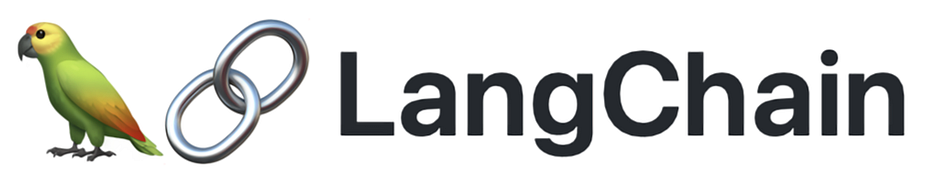

# **Agents vs Chains**

Decision-making:

- Chains execute in a predetermined order.
- Agents decide what to do next based on their reasoning.


Flexibility:

- Chains are fixed once defined.
- Agents can adapt their approach dynamically.


Goal-orientation:

- Chains focus on completing a series of steps.
- Agents focus on achieving a goal, choosing steps as needed.


Complexity:

- Chains are simpler and more predictable.
- Agents are more complex but can handle a wider range of tasks.



An agent could be seen as a "flexible chain" in the sense that it can string together actions like a chain does, but with added decision-making capabilities. It's a higher level of abstraction that incorporates chains as potential components.

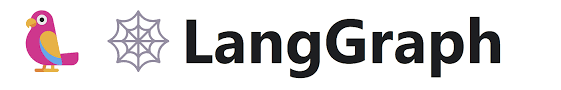

# **Why LangGraph?**

LangGraph offers more complex workflow management compared to normal agents, allowing for sophisticated control flow including branching, looping, and parallel execution. It excels at coordinating multi-agent systems, whereas normal agents typically work independently. LangGraph provides superior state management tools, crucial for long-running or complex processes. Its graph structure enhances visibility and debugging capabilities, making it easier to understand and optimize complex workflows. While normal agents are suitable for simpler tasks, LangGraph is the better choice for intricate, stateful, or multi-step processes that exceed standard agent capabilities.

In [ ]:
# Install relative libraries

%%capture --no-stderr
%pip install -U langgraph langchain_openai

In [ ]:
import getpass
import os
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [ ]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END, MessagesState


# **Graph**

A graph in LangGraph is a structured representation of a workflow, composed of nodes (individual tasks or operations) connected by edges (which define the flow between tasks). It provides a flexible framework for organizing and executing complex, stateful processes involving language models and other computational steps, allowing for non-linear execution paths and persistent state management throughout the workflow.

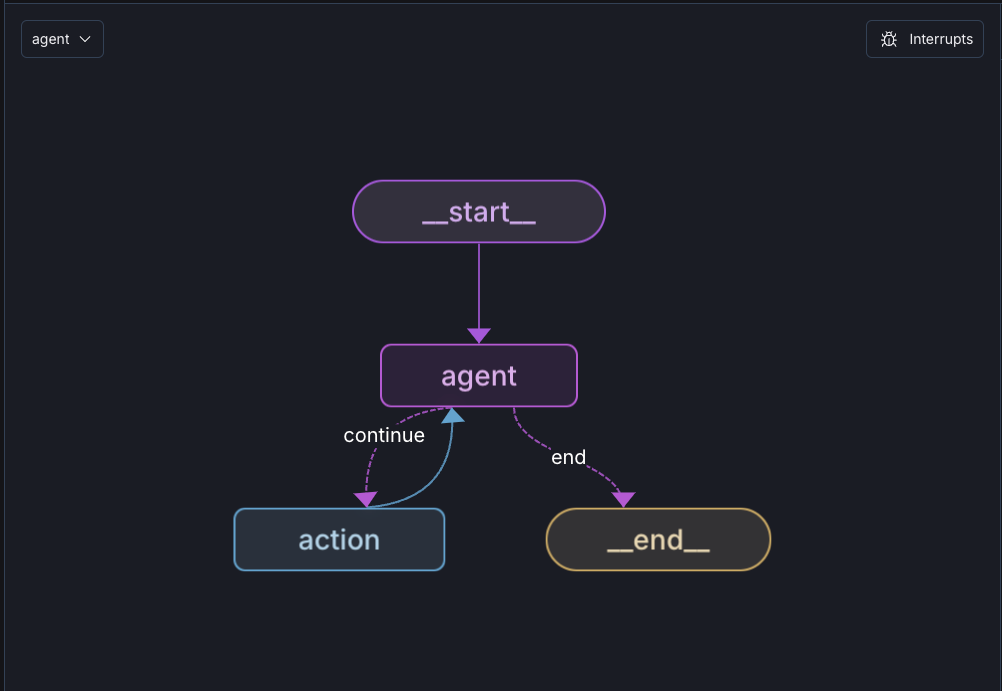

# State

The **state** in langgraph is a data structure used to keep data persistence across the graph.
This means:

- Consistency: It ensures that data remains consistent and accessible throughout the execution of the graph.
- Graph-wide access: Any node within the graph can read from and potentially write to this state.
- Workflow continuity: It allows for the preservation of context and information as the workflow progresses through different nodes of the graph.
- Flexibility: The state can hold various types of data, depending on the needs of the application.
- Central information hub: It acts as a centralized repository for data that needs to be shared or persisted across different parts of the graph.

In [ ]:
class State(TypedDict):
  value: int

# Nodes and Edges

Nodes in LangGraph:

- Function: Nodes represent individual processing units or steps in the workflow.
- Types: Nodes can be various types of components, such as:

    - Language model calls
    - Data processing functions
    - Decision-making units
    - Input/output handlers


- State interaction: Nodes can read from and write to the shared state.
Implementation: Typically implemented as Python functions or classes with a defined interface.

Edges in LangGraph:

- Purpose: Edges define the connections and flow between nodes.
- Directionality: They are usually directed, indicating the flow of execution from one node to another.
- Conditional routing: Edges can incorporate logic to determine the next node based on certain conditions.
- Data passing: While the primary data sharing happens through the state, edges can also facilitate passing specific data between nodes.

The relationship between nodes and edges:

- Graph structure: Together, nodes and edges form the overall structure of the LangGraph application.
- Workflow definition: The arrangement of nodes and edges defines the logic and flow of the application.
- Flexibility: This structure allows for complex, non-linear workflows with branching and looping.
- Modularity: Nodes can be reused and rearranged, connected by different edges to create various workflows.

In [ ]:
# Create a Node
def multiply_by_three(state: State) -> State:
  state["value"] *= 3
  return state

In [ ]:
# Build the graph
graph_workflow = StateGraph(State)

graph_workflow.add_node("multiplier", multiply_by_three)
graph_workflow.add_edge("multiplier", END)
graph_workflow.set_entry_point("multiplier")

graph = graph_workflow.compile()

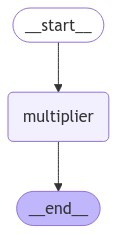

In [ ]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [ ]:
input_value: State = {
  "value": 15
}

result = graph.invoke(input_value)
print(f"The final result is {result['value']}")

The final result is 45


**Ok now we add a CONDITIONAL EDGE**

In [ ]:
def is_more_than_fifty(state: State):
  if state['value'] >= 50:
    return END
  else:
    return 'add_fifty'

def add_fifty(state: State) -> State:
  state['value'] +=50
  return state

graph_flow = StateGraph(State)

graph_flow.add_node("multiplier", multiply_by_three)
graph_flow.add_node("add_fifty", add_fifty)

graph_flow.add_edge("add_fifty", END)

graph_flow.set_entry_point("multiplier")

graph_flow.add_conditional_edges(
    "multiplier",
    is_more_than_fifty,
    {"add_fifty": "add_fifty", END: END}
)

flow = graph_flow.compile()

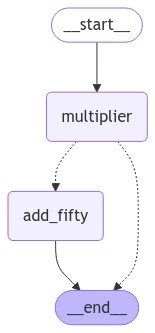

In [ ]:
try:
    display(Image(flow.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [ ]:
# 20 * 3
flow.invoke({"value": 20})

{'value': 60}

In [ ]:
# 2 * 3 < 50 --> (2 * 3) + 50
flow.invoke({"value": 2})

{'value': 56}

# Basic Chatbot

In [ ]:
from typing import Annotated
from langgraph.graph.message import add_messages

In [ ]:
# Added memory stored during program execution.
# NOTE: to store a persistant memory you need a DB and using langchain classes such as SqliteSaver or PostgresSaver.

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [ ]:
class ChatbotState(TypedDict):
  messages: Annotated[list, add_messages]

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")


def bot_node(state: ChatbotState) -> ChatbotState:
    response = llm.invoke(state["messages"])
    # Update message history with response:
    return {"messages": response}


graph_flow = StateGraph(ChatbotState)
graph_flow.add_node("chatbot", bot_node)

graph_flow.add_edge(START, "chatbot")

graph_flow.add_edge("chatbot", END)

graph = graph_flow.compile(checkpointer=memory)

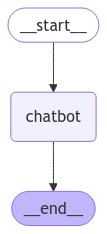

In [ ]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [ ]:
# thread_id is the memory session identifier

def stream_graph_updates(user_input: str, thread_id):
    for event in graph.stream({"messages": [("user", user_input)]}, {"configurable": {"thread_id": thread_id}}):
        for value in event.values():
            print("Assistant:", value["messages"].content)

In [ ]:
thread_id = "11211"
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            break

        stream_graph_updates(user_input, thread_id)
    except:
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input, thread_id)
        break

User: Hi
Assistant: Hello! How can I assist you today?
User: Do you remember me?
Assistant: I don’t have the ability to remember past interactions, but I’m here to help you with whatever you need now! How can I assist you today?
User: My name is Davide
Assistant: Nice to meet you, Davide! How can I assist you today?
User: Do you remember my name?
Assistant: I don’t have the capability to remember details from previous conversations, but I can certainly remember your name during our current chat. How can I help you today, Davide?
User: q
Goodbye!


In [ ]:
# Another way of building the chat
thread_id = "1234"
config = {"configurable": {"thread_id": thread_id}}

while True:
  user_input = input("\nUser: ")
  if user_input.lower() in ["quit", "exit", "q"]:
    break
  events = graph.stream(
      {"messages": [("user", user_input)]}, config, stream_mode="values"
  )
  for event in events:
      # Here im printing just the last message of the Node
      print(event)
      event["messages"][-1].pretty_print()
      # for chunk in event["messages"]:
      #     print(chunk)

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='c898245b-8ca3-48ad-8b4c-1441199f3eca')]}
================================ Human Message =================================

Hi
{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='c898245b-8ca3-48ad-8b4c-1441199f3eca'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f85bea6784', 'finish_reason': 'stop', 'logprobs': None}, id='run-ace46804-06fb-4b8a-b451-a98cafa5e251-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'rea